{'Src IP': <class 'numpy.float32'>, 'Src Port': <class 'numpy.int8'>, 'Dst IP': <class 'numpy.float32'>, 'Dst Port': <class 'numpy.int8'>, 'Protocol': <class 'numpy.int8'>, 'Flow Duration': <class 'numpy.float32'>, 'Total Fwd Packet': <class 'numpy.float32'>, 'Total Bwd packets': <class 'numpy.float32'>, 'Total Length of Fwd Packet': <class 'numpy.float32'>, 'Total Length of Bwd Packet': <class 'numpy.float32'>, 'Fwd Packet Length Max': <class 'numpy.float32'>, 'Fwd Packet Length Min': <class 'numpy.float32'>, 'Fwd Packet Length Mean': <class 'numpy.float32'>, 'Fwd Packet Length Std': <class 'numpy.float32'>, 'Bwd Packet Length Max': <class 'numpy.float32'>, 'Bwd Packet Length Min': <class 'numpy.float32'>, 'Bwd Packet Length Mean': <class 'numpy.float32'>, 'Bwd Packet Length Std': <class 'numpy.float32'>, 'Flow Bytes/s': <class 'numpy.float32'>, 'Flow Packets/s': <class 'numpy.float32'>, 'Flow IAT Mean': <class 'numpy.float32'>, 'Flow IAT Std': <class 'numpy.float32'>, 'Flow IAT Max':

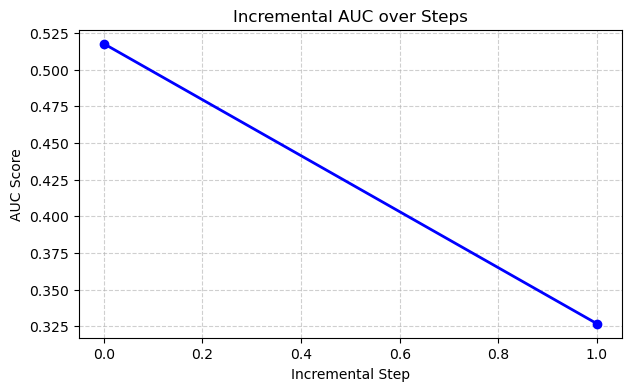

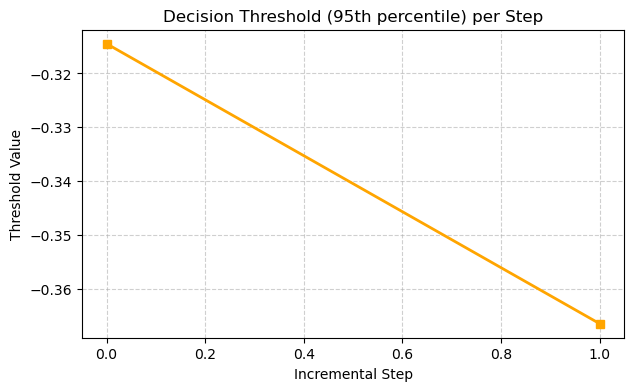

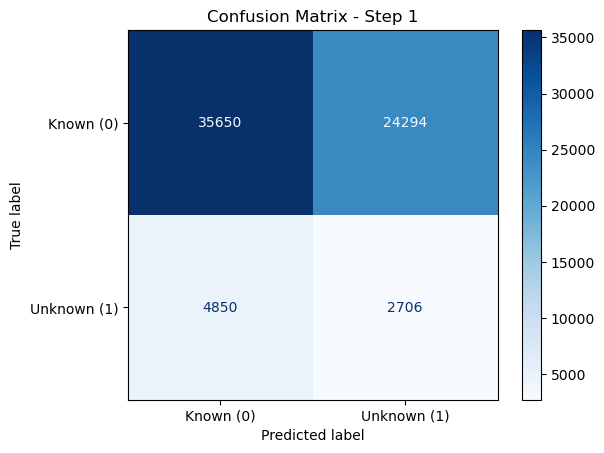

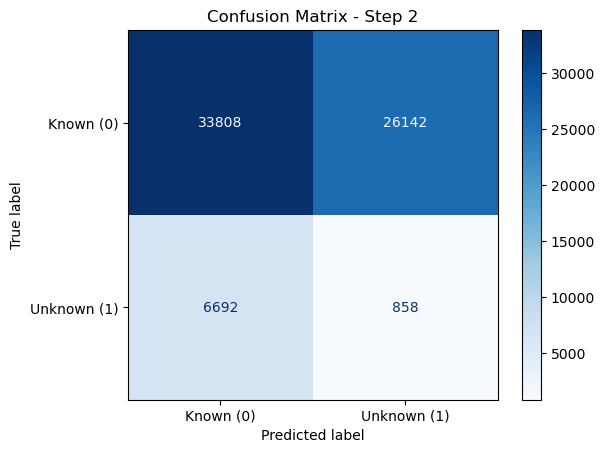

In [ ]:
# ===== INCRE SGDOCSVM =====
import os, sys
from pathlib import Path

import pandas as pd 
import dask.dataframe as dd

# ----- THƯ VIỆN XỬ LÝ CHÍNH
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix, ConfusionMatrixDisplay
)

import torch
import torch.nn as nn

# ----- CÁC THƯ VIỆN HỖ TRỢ -----
import hashlib  
import ipaddress
import json
import glob
import gc

# ----- THƯ VIỆN PLT -----
import matplotlib.pyplot as plt


# Model
from sklearn.linear_model import SGDOneClassSVM


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dir_in = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}.parquet" for i in range(0, 3)]
dir_in_train = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_train.parquet" for i in range(0, 3)]
dir_in_test = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_test.parquet" for i in range(1, 3)]
gc.collect()

# ====== INITIALIZE =====
# ------ OCSVM ------
NU_PARAM = 0.3

# ====== FUNCTION =====
dtypes = {}    
with open('features.json') as json_file:
    data = json.load(json_file)
    for key, type in data.items():
        if type == "int8":
            dtypes[key]= np.int8
        elif type == "float32":
            dtypes[key] = np.float32
    json_file.close()

print(dtypes)

def astype(df):
    for key, type in df.dtypes.items():
        # print(f"Key: {key} \t {type}")
        if type == "int8":
            df[key] = df[key].astype(np.int8)
        elif type == "float32":
            df[key] = df[key].astype(np.float32)
            
    return df

# ============================================================
# ==== INCREMENTAL PIPELINE ====
def incremental_pipeline(train_files, test_files):
    results = []
    clf = SGDOneClassSVM(nu=NU_PARAM,
                         learning_rate='optimal',
                         max_iter=1000,
                         tol=1e-4)
    
    # assert len(train_files) == len(test_files), "Train/Test mismatch!"

    # TURN 0
    df_train = pd.read_parquet(train_files[0])
    df_train = astype(df_train)
    X_train = df_train.drop(["Label", "Binary Label"], axis=1)

    clf.fit(X_train)
    
    del df_train, X_train
    gc.collect()
    
    for step in range(len(test_files)):
        print(f"\n========== Incremental Step {step + 1} ==========")

        # --- LOAD TRAIN & TEST ---
        df_train = pd.read_parquet(train_files[step + 1])
        df_test  = pd.read_parquet(test_files[step])
        df_train = astype(df_train)
        df_test  = astype(df_test)

        print(f"[TRAIN] {df_train['Binary Label'].value_counts().to_dict()}")
        print(f"[TEST]  {df_test['Binary Label'].value_counts().to_dict()}")

        X_train = df_train.drop(["Label", "Binary Label"], axis=1)
        X_test  = df_test.drop(["Label", "Binary Label"], axis=1)
        y_test  = df_test["Binary Label"]

        # --- TEST ---
        y_score = -clf.decision_function(X_test)
        threshold = np.percentile(y_score, 60)
        y_pred = (y_score > threshold).astype(int)

        # Label thật: Binary Label (0 = normal, 1 = attack)
        base_classes = [0]
        y_true = np.isin(y_test, base_classes, invert=True).astype(int)

        # --- METRICS ---
        auc = roc_auc_score(y_true, y_score)
        f1  = f1_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        cm  = confusion_matrix(y_true, y_pred)

        metrics = {
            "step": step,
            "AUC": auc,
            "F1": f1,
            "Precision": pre,
            "Recall": rec,
            "Threshold": threshold,
            "ConfusionMatrix": cm
        }
        print(metrics)
        results.append(metrics)
        
        clf.partial_fit(X_train)    

        gc.collect()

    return results

# ===== RUN =====
if __name__ == '__main__':
    print(input)
    
    results = incremental_pipeline(dir_in_train, dir_in_test)
    # Convert sang DataFrame (trừ CM)
    
    # Convert metrics (exclude CM) sang DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != "ConfusionMatrix"} for r in results])

    # ============================================================
    # ==== PLOTTING ====

    # --- Biểu đồ AUC ---
    plt.figure(figsize=(7,4))
    plt.plot(results_df["step"], results_df["AUC"], marker="o", color="blue", linewidth=2)
    plt.title("Incremental AUC over Steps")
    plt.xlabel("Incremental Step")
    plt.ylabel("AUC Score")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # --- Biểu đồ Threshold ---
    plt.figure(figsize=(7,4))
    plt.plot(results_df["step"], results_df["Threshold"], marker="s", color="orange", linewidth=2)
    plt.title("Decision Threshold (95th percentile) per Step")
    plt.xlabel("Incremental Step")
    plt.ylabel("Threshold Value")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # --- Confusion Matrix mỗi lượt ---
    for r in results:
        cm = r["ConfusionMatrix"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Known (0)", "Unknown (1)"])
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - Step {r['step'] + 1 }")
        plt.show()

In [2]:
from skmultiflow.anomaly_detection import HalfSpaceTrees
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import json, gc

# ====== PATH ======
dir_in_train = [
    f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_train.parquet"
    for i in range(0, 3)
]

dir_in_test = [
    f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_test.parquet"
    for i in range(1, 3)
]


# ======= READ FEATURE TYPES ========
dtypes = {}
with open('features.json') as json_file:
    data = json.load(json_file)
    for k, t in data.items():
        if t == "int8": dtypes[k] = np.int8
        elif t == "float32": dtypes[k] = np.float32


def astype(df):
    for c, t in df.dtypes.items():
        if t == "int8":
            df[c] = df[c].astype(np.int8)
        elif t == "float32":
            df[c] = df[c].astype(np.float32)
    return df


# ============================================================
# ========= INCREMENTAL PIPELINE =============================
# ============================================================
def incremental_pipeline(train_files, test_files):
    results = []

    # ===== Isolation Forest Incremental =====
    clf = HalfSpaceTrees(
        n_trees=25,
        height=12,
        size_limit=100,
        anomaly_threshold=0.6   # không ảnh hưởng vì ta tự tính threshold 95%
    )

    # ===== TURN 0 =====
    df_train0 = pd.read_parquet(train_files[0])
    df_train0 = astype(df_train0)

    X0 = df_train0.drop(["Label", "Binary Label"], axis=1).values
    clf.partial_fit(X0)

    del df_train0, X0
    gc.collect()

    # ===== NEXT STEPS =====
    for step in range(len(test_files)):
        print(f"\n========== Incremental Step {step + 1} ==========")

        df_train = pd.read_parquet(train_files[step + 1])
        df_test = pd.read_parquet(test_files[step])

        df_train = astype(df_train)
        df_test = astype(df_test)

        print("[TRAIN]", df_train["Binary Label"].value_counts().to_dict())
        print("[TEST] ", df_test["Binary Label"].value_counts().to_dict())

        X_train = df_train.drop(["Label", "Binary Label"], axis=1).values
        X_test  = df_test.drop(["Label", "Binary Label"], axis=1).values
        y_test  = df_test["Binary Label"].values

        # ===== SCORING =====
        scores = clf.score_samples(X_test)   # anomaly score
        threshold = np.percentile(scores, 95)

        y_pred = (scores > threshold).astype(int)
        y_true = (y_test != 0).astype(int)

        auc = roc_auc_score(y_true, scores)
        f1 = f1_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        metrics = {
            "step": step,
            "AUC": auc,
            "F1": f1,
            "Precision": pre,
            "Recall": rec,
            "Threshold": threshold,
            "ConfusionMatrix": cm
        }

        print(metrics)
        results.append(metrics)

        # ========== UPDATE ==========
        clf.partial_fit(X_train)

        del df_train, df_test, X_train, X_test
        gc.collect()

    return results


# ============================================================
# ==================== RUN PIPELINE ===========================
# ============================================================
results = incremental_pipeline(dir_in_train, dir_in_test)

results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != "ConfusionMatrix"} for r in results
])

# ======= PLOTTING =======
plt.figure(figsize=(7,4))
plt.plot(results_df["step"], results_df["AUC"], marker="o")
plt.title("AUC per Incremental Step")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(results_df["step"], results_df["Threshold"], marker="s")
plt.title("Threshold per Step")
plt.grid(True)
plt.show()

for r in results:
    disp = ConfusionMatrixDisplay(
        confusion_matrix=r["ConfusionMatrix"],
        display_labels=["Known", "Unknown"]
    )
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — Step {r['step']+1}")
    plt.show()


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations